# 1. Import the Packages

In [130]:
# Standard Python libraries
import os
import random
import time
from datetime import datetime

# Libraries for data manipulation and visualization
import cv2
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

# Libraries for detection and classification
from mtcnn import MTCNN 
from keras_facenet import FaceNet

# 2. Data Set Aquisition

Capturing data set for new user from camera using MTCNN detector

In [131]:
def captureImage():
    # initialize the MTCNN detector
    detector = MTCNN()

    # initialize the video capture object for the default camera
    cam = cv2.VideoCapture(0)

    # initialize catured frame variable

    while True:
        # read the frame from the camera
        ret, frame = cam.read()

        # detect faces using MTCNN
        faces = detector.detect_faces(frame)

        # draw bounding boxes around the faces
        for face in faces:
            x, y, w, h = face['box']
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 2)

        # show the resulting frame
        cv2.imshow('Real-time Face Detection', frame)

        # press 'q' key to exit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # release the video capture object and close all windows
    cam.release()
    cv2.destroyAllWindows()

## 3. Preprocessing Image

### 3.1. MTCNN Part

Extract faces from captured image using MTCNN and resize the image into 160x160. After that, do flip and contrast stretching to resized image

In [132]:
class FACELOADING:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160, 160)
        self.X = []
        self.Y = []
        self.detector = MTCNN()

    def extract_faces(self, filename):
        img = cv2.imread(filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        hasil_deteksi = self.detector.detect_faces(img)

        # Getting x, y, w, h from image 'box'
        x, y, w, h = hasil_deteksi[0]['box']
        x, y, w, h = abs(x), abs(y), abs(w), abs(h)

        # Draw rectangle box on detected face
        img = cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 10)

        wajah = img[y:y + h, x:x + w]
        wajah_arr = cv2.resize(wajah, self.target_size)
        return wajah_arr

    def load_faces(self, dir, class_label):
        FACES = []
        for im_name in os.listdir(dir):
            try:
                path = os.path.join(dir, im_name)
                single_face = self.extract_faces(path)
                FACES.append(single_face)
                self.Y.append(class_label)
            except Exception as e:
                pass
        return FACES

    def parse_filename(self, filename):
        # Mengambil NIM dan Nama dari nama file dengan pola "NIM_Nama_i.jpg"
        nim, nama, _ = filename.split('_')
        return nim, nama

    def load_classes(self):
        for sub_dir in os.listdir(self.directory):
            path = os.path.join(self.directory, sub_dir)
            FACES = self.load_faces(path, sub_dir)
            labels = [sub_dir for _ in range(len(FACES))]

            print(f"Loaded Successfully: {len(labels)}")

            # Append original images to X and Y
            # self.X.extend(FACES)
            # self.Y.extend(labels)

            # Create subdirectories based on class names
            dataset_folder = "datawajah"
            output_dir = os.path.join(dataset_folder, sub_dir)
            os.makedirs(output_dir, exist_ok=True)

            # Save images to subdirectories
            num_images = len(FACES)
            for i, face in enumerate(FACES):
                nim, nama = self.parse_filename(os.listdir(os.path.join(self.directory, sub_dir))[i])
                
                # Save and append original images to X and Y
                self.X.append(face)
                self.Y.append(sub_dir)
                original_filename = f"{nim}_{nama}_{i+1}.jpg"
                output_path_original = os.path.join(output_dir, original_filename)
                cv2.imwrite(output_path_original, cv2.cvtColor(face, cv2.COLOR_RGB2BGR))

                # Apply flipping, save, and append flipped image to X and Y
                flipped_face = cv2.flip(face, 1)  # 1 for horizontal flip
                self.X.append(flipped_face)
                self.Y.append(sub_dir)
                flipped_filename = f"{nim}_{nama}_{i+num_images+1}.jpg"
                output_path_flip = os.path.join(output_dir, flipped_filename)
                cv2.imwrite(output_path_flip, cv2.cvtColor(flipped_face, cv2.COLOR_RGB2BGR))

                # Apply contrast stretching, save, and append contrast-stretched image to X and Y
                contrast_stretched_face = self.contrast_stretching(face)
                self.X.append(contrast_stretched_face)
                self.Y.append(sub_dir)
                stretched_filename = f"{nim}_{nama}_{i+2*num_images+1}.jpg"
                output_path_stretch = os.path.join(output_dir, stretched_filename)
                cv2.imwrite(output_path_stretch, cv2.cvtColor(contrast_stretched_face, cv2.COLOR_RGB2BGR))
                
        return np.asarray(self.X), np.asarray(self.Y)

    def contrast_stretching(self, image):
        # Compute minimum and maximum pixel values for each channel
        min_val = np.min(image, axis=(0, 1))
        max_val = np.max(image, axis=(0, 1))

        # Perform contrast stretching for each channel
        stretched = (image - min_val) * (255.0 / (max_val - min_val))
        stretched = np.clip(stretched, 0, 255).astype(np.uint8)

        return stretched

# Gunakan kelas FACELOADING dengan folder direktori "capturedfaces"
face_loader = FACELOADING("capturedfaces")
X, Y = face_loader.load_classes()

1/1 [==============================] - 0s 24ms/step
Loaded Successfully: 50
1/1 [==============================] - 0s 27ms/step
Loaded Successfully: 50


In [133]:
print(f"Unique Labels: {set(Y)}")
print(f'Total Images in Array: {len(X)}')

Unique Labels: {'rizky-nurhadhi', 'rizky-mahesa-ramadhan'}
Total Images in Array: 300


Creating dataframe that containing available images from extracted faces and checking total files in the folder

In [134]:
# Initialize main dataset folder
capture_folder = "capturedfaces"

# Initialize main dataset folder
dataset_folder = "datawajah"

In [135]:
def create_dataframe():
    root_folder = dataset_folder

    data = []
  
    # Iterate through the main folder and subfolders
    for root, dirs, files in os.walk(root_folder):
        for file in files:
        # Get the subfolder name (classes)
            classes = os.path.basename(root)

            # Get the full path of the image
            image_path = os.path.join(classes, file)

            # Add data to the list
            data.append({'Classes': classes, 'File Name': file, 'Image Path': image_path})

    # Create a dataframe from the data list
    df = pd.DataFrame(data)

    # Save the dataframe to an Excel file
    excel_file_name = 'dataframe_and_model_files/faces_train_data.xlsx'
    df.to_excel(excel_file_name, index=False)

    print("Dataframe successfully saved to", excel_file_name)

    return df

In [136]:
def total_images_per_class(df):
    # Function to calculate the total number of files in a folder.
    def total_file(classes):
        return len(df[df['Classes'] == classes].values)

    # Iterate through unique classes and print the total number of files for each class
    unique_classes = df['Classes'].unique()
    print("Total number of images in each class :")
    for classes in unique_classes:
        count = total_file(classes)
        print(f"'{classes}': {count} images")

In [137]:
# Create the dataframe
df = create_dataframe()

# Calculate and print the total number of images in each class
total_images_per_class(df)

Dataframe successfully saved to dataframe_and_model_files/faces_train_data.xlsx
Total number of images in each class :
'rizky-mahesa-ramadhan': 150 images
'rizky-nurhadhi': 150 images


In [138]:
df.sample(5)

,Classes,File Name,Image Path
205,rizky-nurhadhi,1207070113_Rizky Nurhadhi_149.jpg,rizky-nurhadhi\1207070113_Rizky Nurhadhi_149.jpg
58,rizky-mahesa-ramadhan,1207070112_Rizky Mahesa Ramadhan_16.jpg,rizky-mahesa-ramadhan\1207070112_Rizky Mahesa ...
170,rizky-nurhadhi,1207070113_Rizky Nurhadhi_117.jpg,rizky-nurhadhi\1207070113_Rizky Nurhadhi_117.jpg
20,rizky-mahesa-ramadhan,1207070112_Rizky Mahesa Ramadhan_117.jpg,rizky-mahesa-ramadhan\1207070112_Rizky Mahesa ...
254,rizky-nurhadhi,1207070113_Rizky Nurhadhi_58.jpg,rizky-nurhadhi\1207070113_Rizky Nurhadhi_58.jpg


### 3.2. FaceNet Part

Embed the dataset to 512 dimension image (1x1x512) and save it into .npz file

In [139]:
embedder = FaceNet()

def get_embedding(face_image):
    face_image = face_image.astype('float32') # 3D(160x160x3)
    face_image = np.expand_dims(face_image, axis=0) # 4D(Nonex160x160x3)
    
    yhat = embedder.embeddings(face_image)

    return yhat[0] #512D image (1x1x152)

In [140]:
EMBEDDED_X = []

for face_image in X:
    EMBEDDED_X.append(get_embedding(face_image))

EMBEDDED_X = np.asarray(EMBEDDED_X)

1/1 [==============================] - 0s 63ms/step


In [141]:
embedded_file_name = "dataframe_and_model_files/embedded_dataset.npz"
np.savez_compressed(embedded_file_name, EMBEDDED_X, Y)
print("Embedded dataset successfully saved to", embedded_file_name)

print(f"Unique Labels: {set(Y)}")
print(f'Total Embedded Images in Array: {len(EMBEDDED_X)}')

Embedded dataset successfully saved to dataframe_and_model_files/embedded_dataset.npz
Unique Labels: {'rizky-nurhadhi', 'rizky-mahesa-ramadhan'}
Total Embedded Images in Array: 300


1/1 [==============================] - 0s 71ms/step


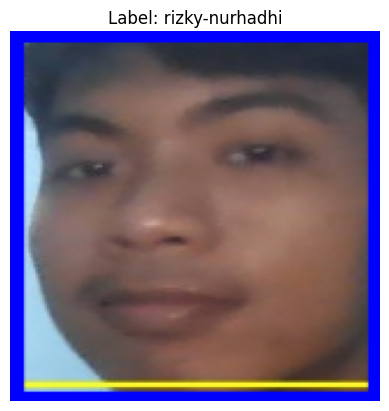

Embedded Vector: [ 6.12996332e-02  4.40323353e-02 -1.85329057e-02  1.86101850e-02
  6.29923493e-02 -5.11934934e-03  4.06069122e-02 -1.32097211e-02
 -6.10804968e-02  2.35213898e-02  4.54185680e-02 -5.44841252e-02
 -2.32348107e-02 -1.39010493e-02  3.83528285e-02 -5.62361777e-02
  5.84400557e-02  8.50165114e-02 -2.86208838e-02  4.00433615e-02
  6.68579489e-02  3.52319591e-02  2.86578443e-02 -1.99865140e-02
  7.32369954e-03  2.87332060e-03  6.34072646e-02 -3.43998522e-02
  5.76010123e-02 -3.80203389e-02  2.91428100e-02  6.86086193e-02
 -2.25946642e-02  4.48562428e-02  7.52554983e-02 -4.21125256e-02
 -3.97724658e-02 -7.30769187e-02 -1.28995543e-02 -2.15918049e-02
 -4.00948673e-02 -6.00347705e-02 -1.28062600e-02 -3.35582644e-02
 -6.21463880e-02 -1.99370217e-02 -3.37713957e-02 -3.86078730e-02
 -1.33879157e-02  3.20002735e-02  2.98623145e-02 -1.01080552e-01
  4.69231084e-02  5.95655069e-02  1.57769956e-02 -8.48271847e-02
 -2.10374519e-02  2.01627873e-02  1.08608706e-02  2.91040372e-02
  2.1995

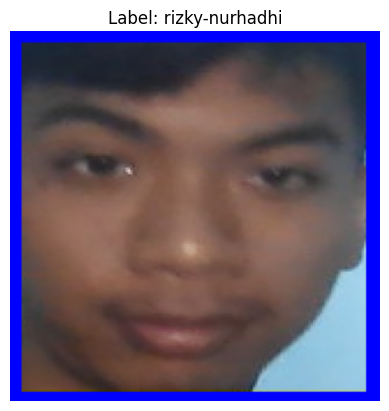

Embedded Vector: [ 0.0703881   0.04118634 -0.00459038  0.02144033  0.05650086 -0.02590676
  0.02525694 -0.04028561 -0.054931    0.00129056  0.01982568 -0.06606544
 -0.02442477  0.0255218   0.0625358  -0.02485846  0.0621598   0.06051663
 -0.02024407  0.05938668  0.0317344   0.01894813  0.00833167 -0.00927986
  0.02018746  0.00434523  0.04349055 -0.04039139  0.10810623 -0.05790138
 -0.01711019  0.05226977 -0.0146241   0.02290157  0.05390792 -0.02016393
 -0.0642281  -0.06565831  0.01355151  0.02298263 -0.03425716 -0.0764586
 -0.01502454 -0.06107406 -0.04777983 -0.00124411 -0.03948535 -0.00920566
 -0.02780457  0.07687276  0.05850013 -0.09165309  0.00506423  0.05985008
 -0.00957151 -0.10110863 -0.00520774  0.00516529  0.04366989 -0.00271418
  0.04020731  0.04415855 -0.00375989  0.02881369 -0.00647913 -0.04758494
  0.00980672 -0.06304166  0.02175855  0.01940654 -0.03252585  0.01056688
 -0.04421034  0.01958539 -0.00922441  0.01592169  0.02998939 -0.0353119
  0.00617995  0.04002274  0.06938225

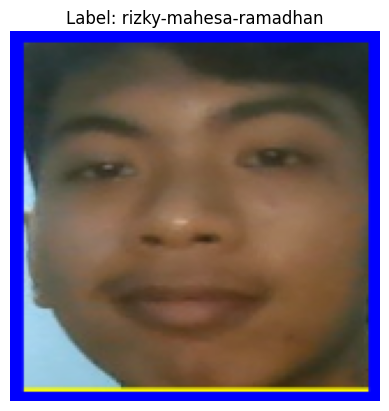

Embedded Vector: [ 5.92728853e-02  2.87014395e-02 -9.50104464e-03  3.60796340e-02
  6.26110435e-02  5.67951193e-03  2.79577710e-02 -3.50584425e-02
 -5.88871986e-02  1.31141758e-02  4.69428413e-02 -6.04998171e-02
 -2.85780244e-02 -8.88144225e-03  5.35320938e-02 -5.05488627e-02
  6.29953519e-02  9.07346234e-02 -5.04914811e-03  3.01535577e-02
  4.84434217e-02  3.57823782e-02  5.53866476e-02 -1.08043116e-03
  6.24074740e-03  2.79989950e-02  6.27718195e-02 -4.21321355e-02
  6.00195751e-02 -4.32090685e-02  5.27742552e-03  7.91779533e-02
 -1.17848543e-02  2.13185847e-02  7.57102966e-02 -2.50866823e-02
 -3.19468193e-02 -7.54933432e-02 -3.44889169e-03 -7.76490523e-03
 -3.78693193e-02 -4.45899591e-02 -1.74559467e-02 -6.57051802e-02
 -4.88509797e-02 -2.52870843e-02 -3.14348824e-02 -1.11161694e-02
 -4.04634289e-02  4.42581177e-02  2.71322988e-02 -7.86911994e-02
  2.28500087e-02  6.86773285e-02 -3.58317426e-04 -9.65841115e-02
  3.61731183e-03  2.24398971e-02  2.09664498e-02  3.14411186e-02
  2.8375

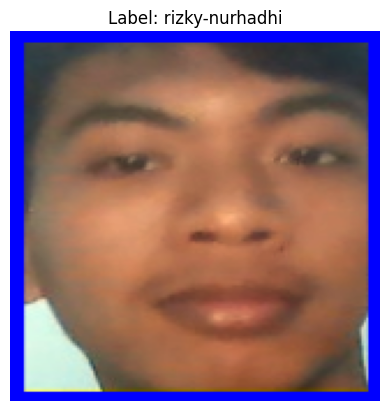

Embedded Vector: [ 0.05248126  0.03980042 -0.00139361  0.02297204  0.06074679  0.00284487
  0.02314064 -0.03081809 -0.04619677  0.02056807  0.03916881 -0.0582631
 -0.02525604  0.0007618   0.07161853 -0.05729423  0.07502794  0.07578673
 -0.01172424  0.0271836   0.0564182   0.05645288  0.05994862  0.00469852
 -0.0001965   0.04786246  0.05820103 -0.04642758  0.07930931 -0.04981249
 -0.01021415  0.07118315 -0.00839027  0.01826271  0.08142612 -0.01403364
 -0.0411942  -0.07676577  0.01144688  0.00939171 -0.01202619 -0.05253189
 -0.01543185 -0.05745614 -0.07033526 -0.01942695 -0.02525473  0.00533721
 -0.07155974  0.04136395  0.03390761 -0.06184888  0.00295559  0.0413554
  0.00052084 -0.09789164  0.01004918 -0.00744724  0.02289295  0.02313921
  0.02150058  0.08308189 -0.02542193  0.00233208  0.01890011 -0.0775929
  0.00498156 -0.06192104  0.03876643  0.02386007  0.01256562  0.02688403
 -0.05591409  0.00201804  0.03313247  0.03696608  0.03272798 -0.01065728
 -0.02226183  0.0167959   0.07349136 

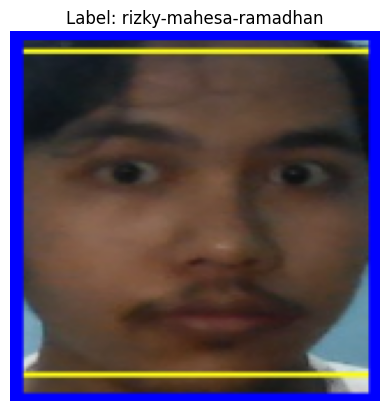

Embedded Vector: [ 0.05609322  0.05012023 -0.01601037  0.04030814  0.05985892 -0.02907818
  0.06893817  0.02467867 -0.01198694 -0.0127723   0.09838618 -0.01114568
 -0.00510523 -0.03247825 -0.01260954  0.03219459  0.05544485  0.08042243
 -0.06019517  0.04001637  0.00607468 -0.01559759  0.00823727 -0.05438042
 -0.02049301 -0.03054596  0.01359444 -0.0716487   0.04432027 -0.02194824
  0.01111815  0.0039396  -0.04617511  0.05371757  0.0335749  -0.0087501
  0.05909748 -0.10209264  0.00147345  0.02714179  0.02175637 -0.05903485
  0.0119116  -0.00025919 -0.07500655  0.00898361 -0.05130698  0.01868725
  0.01175196  0.01195661 -0.00679594 -0.08214837  0.01072887  0.06085751
  0.02381    -0.08438798 -0.04008218 -0.03516614 -0.01402733 -0.01719106
 -0.00567938  0.08314626 -0.0592099   0.0661051  -0.00213757 -0.07726252
 -0.02071639 -0.02962398  0.11000079 -0.05630571 -0.04658642 -0.0189833
 -0.03984641 -0.01352401  0.04461612 -0.03684188  0.00713151 -0.0397634
 -0.01147179 -0.0140484  -0.00868875 

In [145]:
# Load the embedded dataset
loaded_data = np.load("dataframe_and_model_files/embedded_dataset.npz")
EMBEDDED_X, Y = loaded_data['arr_0'], loaded_data['arr_1']

# Select a few samples
num_samples = 5
selected_indices = np.random.choice(len(EMBEDDED_X), num_samples, replace=False)

# Iterate through samples and display original images and their embeddings
for index in selected_indices:
    original_image = X[index]
    label = Y[index]

    # Get the corresponding embedded vector
    embedded_vector = get_embedding(original_image)

    # Display the original image
    plt.imshow(original_image)
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

    print(f"Embedded Vector: {embedded_vector}")

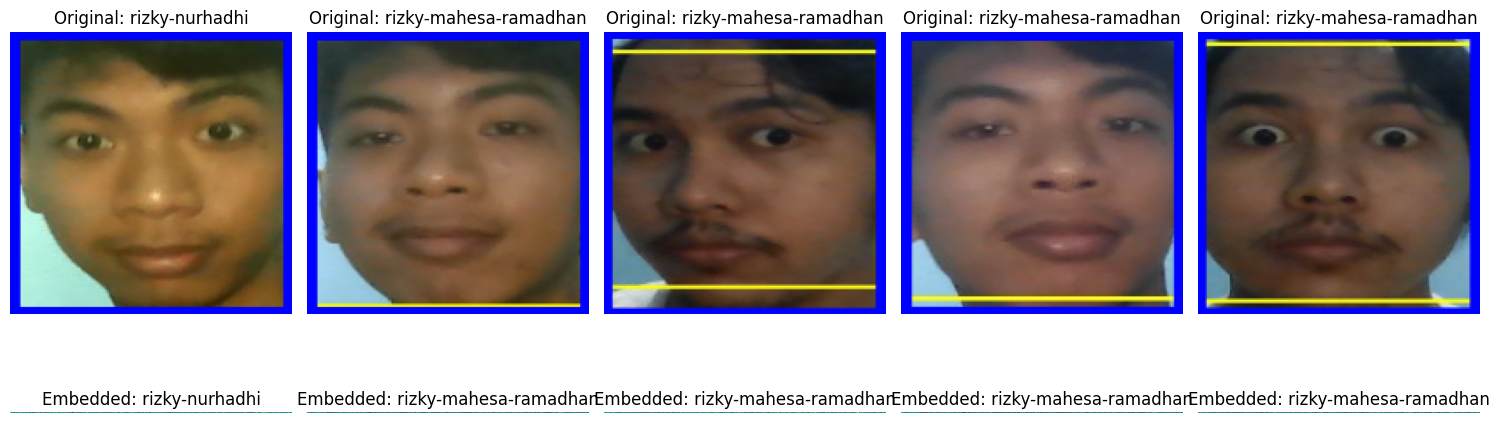

In [149]:
# Choose a few random indices
num_display_samples = 5
sample_indices = random.sample(range(len(EMBEDDED_X)), num_display_samples)

# Display the sample images with their corresponding labels and embeddings
plt.figure(figsize=(15, 6))
for i, index in enumerate(sample_indices):
    plt.subplot(2, num_display_samples, i + 1)
    plt.imshow(X[index])
    plt.title(f"Original: {Y[index]}")
    plt.axis('off')

    plt.subplot(2, num_display_samples, i + num_display_samples + 1)
    plt.imshow(EMBEDDED_X[index].reshape((1, -1)))
    plt.title(f"Embedded: {Y[index]}")
    plt.axis('off')

plt.tight_layout()

In [144]:
# Check correspondence between images in 'X' and labels in 'Y'
for i in range(len(X)):
    print(f"Label: {Y[i]}, Image Path: {os.path.basename(os.path.normpath(df['Image Path'].iloc[i]))}")

Label: rizky-mahesa-ramadhan, Image Path: 1207070112_Rizky Mahesa Ramadhan_1.jpg
Label: rizky-mahesa-ramadhan, Image Path: 1207070112_Rizky Mahesa Ramadhan_10.jpg
Label: rizky-mahesa-ramadhan, Image Path: 1207070112_Rizky Mahesa Ramadhan_100.jpg
Label: rizky-mahesa-ramadhan, Image Path: 1207070112_Rizky Mahesa Ramadhan_101.jpg
Label: rizky-mahesa-ramadhan, Image Path: 1207070112_Rizky Mahesa Ramadhan_102.jpg
Label: rizky-mahesa-ramadhan, Image Path: 1207070112_Rizky Mahesa Ramadhan_103.jpg
Label: rizky-mahesa-ramadhan, Image Path: 1207070112_Rizky Mahesa Ramadhan_104.jpg
Label: rizky-mahesa-ramadhan, Image Path: 1207070112_Rizky Mahesa Ramadhan_105.jpg
Label: rizky-mahesa-ramadhan, Image Path: 1207070112_Rizky Mahesa Ramadhan_106.jpg
Label: rizky-mahesa-ramadhan, Image Path: 1207070112_Rizky Mahesa Ramadhan_107.jpg
Label: rizky-mahesa-ramadhan, Image Path: 1207070112_Rizky Mahesa Ramadhan_108.jpg
Label: rizky-mahesa-ramadhan, Image Path: 1207070112_Rizky Mahesa Ramadhan_109.jpg
Label: 

## GUI